In [3]:
import pandas as pd

# Read the text dataset
df = pd.read_csv('household_power_consumption.txt', sep=';')  # adjust separator if needed

# Define Excel max rows
max_rows = 1_048_000

# Write multiple sheets
with pd.ExcelWriter('household_power_consumption.xlsx', engine='openpyxl') as writer:
    for i in range(0, len(df), max_rows):
        sheet_name = f"Sheet_{i//max_rows + 1}"
        df.iloc[i:i+max_rows].to_excel(writer, sheet_name=sheet_name, index=False)

print("✅ Dataset saved into multiple sheets successfully!")

C:\Users\tejal\AppData\Local\Temp\ipykernel_16416\4000796545.py:4: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption.txt', sep=';')  # adjust separator if needed


✅ Dataset saved into multiple sheets successfully!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None
       Sub_metering_3
count    2.049280e+06
mean     6.458447e+00
std      8.437154e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.700000e+01
max      3.100000e+01
         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2

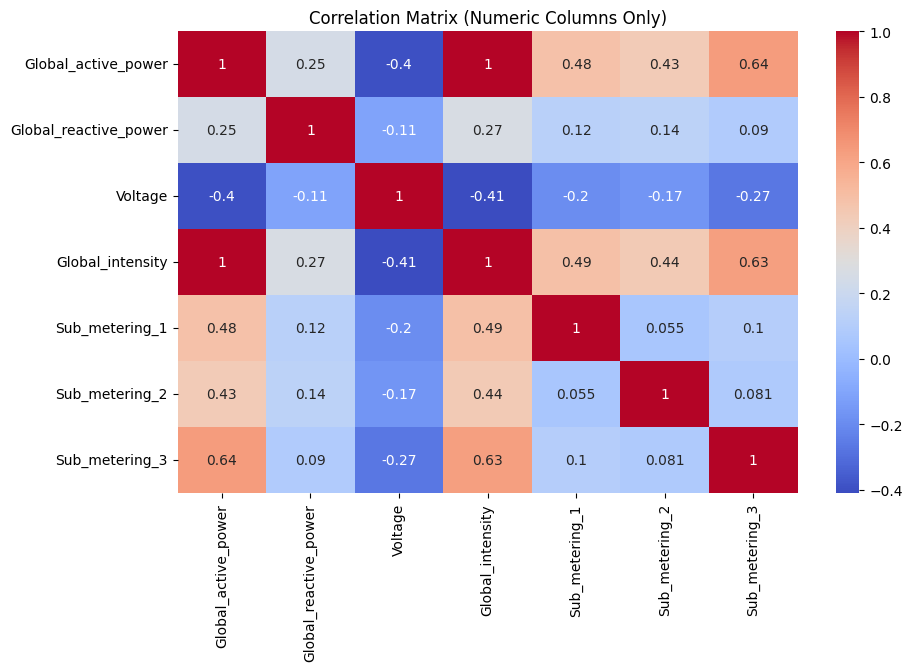

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load all sheets and merge
df = pd.read_excel('household_power_consumption.xlsx', sheet_name=None)
df_main = pd.concat(df.values(), ignore_index=True)

# Explore structure
print(df_main.info())
print(df_main.describe())
print(df_main.head())

# ---- FIX STARTS HERE ----

# Convert possible numeric columns (e.g., 'Global_active_power') to numeric safely
for col in df_main.columns:
    df_main[col] = pd.to_numeric(df_main[col], errors='coerce')

# Select only numeric columns
numeric_df = df_main.select_dtypes(include=['float64', 'int64'])

# Drop columns with all NaN values (optional but cleaner)
numeric_df = numeric_df.dropna(axis=1, how='all')

# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Numeric Columns Only)")
plt.show()
# ---- FIX ENDS HERE ----

In [5]:
df

{'Sheet_1':                Date      Time Global_active_power Global_reactive_power  \
 0        16/12/2006  17:24:00               4.216                 0.418   
 1        16/12/2006  17:25:00               5.360                 0.436   
 2        16/12/2006  17:26:00               5.374                 0.498   
 3        16/12/2006  17:27:00               5.388                 0.502   
 4        16/12/2006  17:28:00               3.666                 0.528   
 ...             ...       ...                 ...                   ...   
 1047995  13/12/2008  11:59:00               0.294                 0.000   
 1047996  13/12/2008  12:00:00               0.290                 0.046   
 1047997  13/12/2008  12:01:00               0.284                 0.046   
 1047998  13/12/2008  12:02:00               0.292                 0.000   
 1047999  13/12/2008  12:03:00               0.292                 0.000   
 
          Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
 0     

In [6]:
import pandas as pd
import numpy as np

# -------------------
# 0) Load & merge
# -------------------
df_all = pd.read_excel("household_power_consumption.xlsx", sheet_name=None)
df_main = pd.concat(df_all.values(), ignore_index=True)

# Normalize column names (helps avoid typos / space issues)
df_main.columns = [c.strip().replace(" ", "_") for c in df_main.columns]

# -------------------
# 1) Parse Date / Time robustly
# -------------------
def find(df, name):
    # case/underscore-insensitive lookup
    for c in df.columns:
        if c.lower().replace("","") == name.lower().replace("",""):
            return c
    return None

date_col = find(df_main, "Date")
time_col = find(df_main, "Time")

# Don't drop everything at the start; coerce and then filter thoughtfully.
if date_col:
    # Many power datasets are DD/MM/YYYY: use dayfirst=True
    df_main[date_col] = pd.to_datetime(df_main[date_col], errors="coerce", dayfirst=True)

if time_col:
    # Keep time as string (e.g., '18:22:00'); if it's already a time, this still works
    time_str = df_main[time_col].astype(str).str.strip()
    # Combine safely using the parsed Date (formatted back to YYYY-MM-DD)
    if date_col:
        date_str = df_main[date_col].dt.strftime("%Y-%m-%d")
        df_main["Datetime"] = pd.to_datetime(date_str + " " + time_str, errors="coerce")
    else:
        # If no Date col, try parsing Time alone (rarely useful for ML)
        df_main["Datetime"] = pd.to_datetime(time_str, errors="coerce")
else:
    # If a Datetime-like column exists, try parsing it directly
    dt_col = find(df_main, "Datetime") or find(df_main, "Timestamp")
    if dt_col:
        df_main["Datetime"] = pd.to_datetime(df_main[dt_col], errors="coerce", dayfirst=True)

# -------------------
# 2) Coerce numeric columns
# -------------------
num_candidates = [
    "Global_active_power","Global_reactive_power","Voltage","Global_intensity",
    "Sub_metering_1","Sub_metering_2","Sub_metering_3"
]

# Build a mapping from canonical name -> actual column in df
colmap = {}
for target in num_candidates:
    c = find(df_main, target)
    if c: colmap[target] = c

# Clean: replace '?' and comma-decimals, then to_numeric
for tgt, col in colmap.items():
    df_main[col] = (
        df_main[col]
        .astype(str)
        .str.replace(",", ".", regex=False)   # "4,52" -> "4.52"
        .replace({"?": np.nan, "nan": np.nan})
    )
    df_main[col] = pd.to_numeric(df_main[col], errors="coerce")

# -------------------
# 3) Minimal NA filtering (only for required columns)
# -------------------
required_cols = [colmap.get("Global_active_power"),
                 colmap.get("Global_reactive_power"),
                 colmap.get("Voltage"),
                 colmap.get("Global_intensity")]
required_cols = [c for c in required_cols if c]  # drop missing ones

before = len(df_main)
# Drop rows where target or required numeric columns are missing
subset = [colmap.get("Global_active_power")] + required_cols
subset = [c for c in subset if c]
df_main = df_main.dropna(subset=subset)
after = len(df_main)

print(f"Rows before NA filter: {before}  | after: {after}  | dropped: {before - after}")

# -------------------
# 4) Add time features (only if we have a valid Datetime)
# -------------------
if "Datetime" in df_main.columns:
    valid_dt = df_main["Datetime"].notna().sum()
    print(f"Valid Datetime rows: {valid_dt}/{len(df_main)}")
    df_main["Hour"] = df_main["Datetime"].dt.hour
    df_main["Day"] = df_main["Datetime"].dt.day
    df_main["Month"] = df_main["Datetime"].dt.month
    df_main["Weekday"] = df_main["Datetime"].dt.weekday
else:
    print("No 'Datetime' column available; skipping time features.")

# -------------------
# 5) Scale features safely (only if rows > 0)
# -------------------
from sklearn.preprocessing import StandardScaler

scale_cols = [colmap.get("Global_active_power"),
              colmap.get("Global_reactive_power"),
              colmap.get("Voltage"),
              colmap.get("Global_intensity")]
scale_cols = [c for c in scale_cols if c]

if len(df_main) == 0:
    raise ValueError(
        "No rows left after cleaning. Check date parsing (dayfirst=True?) and "
        "the presence of '?' or non-numeric values in key columns."
    )

# You can also do a quick sanity check on how many NaNs remain in your scale columns:
print("Remaining NaNs in scale columns:", df_main[scale_cols].isna().sum().to_dict())

# Drop any rows that still have NaNs in the exact columns we will scale
df_main = df_main.dropna(subset=scale_cols)

# Now scale
scaler = StandardScaler()
df_main[scale_cols] = scaler.fit_transform(df_main[scale_cols])

print("Scaling complete. Shape:",df_main.shape)

Rows before NA filter: 2075259  | after: 2049280  | dropped: 25979
Valid Datetime rows: 2049280/2049280
Remaining NaNs in scale columns: {'Global_active_power': 0, 'Global_reactive_power': 0, 'Voltage': 0, 'Global_intensity': 0}
Scaling complete. Shape: (2049280, 14)


In [7]:
df_main

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,Hour,Day,Month,Weekday
0,2006-12-16,17:24:00,2.955077,2.610721,-1.851816,3.098789,0.0,1.0,17.0,2006-12-16 17:24:00,17,16,12,5
1,2006-12-16,17:25:00,4.037085,2.770406,-2.225274,4.133800,0.0,1.0,16.0,2006-12-16 17:25:00,17,16,12,5
2,2006-12-16,17:26:00,4.050326,3.320432,-2.330213,4.133800,0.0,2.0,17.0,2006-12-16 17:26:00,17,16,12,5
3,2006-12-16,17:27:00,4.063567,3.355917,-2.191324,4.133800,0.0,1.0,17.0,2006-12-16 17:27:00,17,16,12,5
4,2006-12-16,17:28:00,2.434881,3.586573,-1.592556,2.513782,0.0,1.0,17.0,2006-12-16 17:28:00,17,16,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,-0.137724,-1.097519,-0.126500,-0.141247,0.0,0.0,0.0,2010-11-26 20:58:00,20,26,11,4
2075255,2010-11-26,20:59:00,-0.139616,-1.097519,-0.259217,-0.141247,0.0,0.0,0.0,2010-11-26 20:59:00,20,26,11,4
2075256,2010-11-26,21:00:00,-0.145291,-1.097519,-0.314772,-0.186248,0.0,0.0,0.0,2010-11-26 21:00:00,21,26,11,4
2075257,2010-11-26,21:01:00,-0.149074,-1.097519,-0.351810,-0.186248,0.0,0.0,0.0,2010-11-26 21:01:00,21,26,11,4


In [8]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- 0) Helpers ----------
def find_col(df, name):
    # case-insensitive, ignores underscores
    name_norm = name.lower().replace("_","")
    for c in df.columns:
        if c.lower().replace("_","") == name_norm:
            return c
    return None

def coerce_numeric(series):
    return pd.to_numeric(
        series.astype(str).str.replace(",", ".", regex=False).replace({"?": np.nan, "nan": np.nan}),
        errors="coerce"
    )

# ---------- 1) Make sure key columns exist & are clean ----------
# Try to locate canonical columns (adjust here if your headers differ)
col_gap = find_col(df_main, "Global_active_power")
col_grp = find_col(df_main, "Global_reactive_power")
col_volt = find_col(df_main, "Voltage")
col_int = find_col(df_main, "Global_intensity")
col_date = find_col(df_main, "Date")
col_time = find_col(df_main, "Time")
col_dt = find_col(df_main, "Datetime")  # maybe you already created it

# Parse Datetime robustly (dayfirst common for '16/12/2006')
if col_dt is None:
    if col_date is not None:
        df_main[col_date] = pd.to_datetime(df_main[col_date], errors="coerce", dayfirst=True)
    if col_time is not None and col_date is not None:
        df_main["Datetime"] = pd.to_datetime(df_main[col_date].dt.strftime("%Y-%m-%d") + " " +
                                             df_main[col_time].astype(str), errors="coerce")
    elif col_date is not None:
        df_main["Datetime"] = df_main[col_date]  # fallback
else:
    df_main["Datetime"] = pd.to_datetime(df_main[col_dt], errors="coerce", dayfirst=True)

# Derive time features safely
if "Datetime" in df_main.columns:
    df_main["Hour"] = df_main["Datetime"].dt.hour
    df_main["Weekday"] = df_main["Datetime"].dt.weekday
    df_main["Month"] = df_main["Datetime"].dt.month
else:
    # If no datetime, create placeholders to avoid KeyErrors
    df_main["Hour"] = np.nan
    df_main["Weekday"] = np.nan
    df_main["Month"] = np.nan

# Peak-hour feature (create if missing)
if "Is_peak_hour" not in df_main.columns:
    df_main["Is_peak_hour"] = df_main["Hour"].apply(lambda h: 1 if pd.notna(h) and 17 <= int(h) <= 22 else 0)

# Rolling power feature (create if missing)
if "Power_rolling_3h" not in df_main.columns:
    # Use min_periods=1 to avoid NaNs in first two rows
    if col_gap is not None:
        # Coerce GAP to numeric before rolling
        df_main[col_gap] = coerce_numeric(df_main[col_gap])
        df_main["Power_rolling_3h"] = df_main[col_gap].rolling(window=3, min_periods=1).mean()
    else:
        df_main["Power_rolling_3h"] = np.nan

# Coerce all numeric predictors to numeric (handles '?' and comma-decimals)
for c in [col_grp, col_volt, col_int]:
    if c is not None:
        df_main[c] = coerce_numeric(df_main[c])

# Also ensure the target is numeric
if col_gap is None:
    raise ValueError("Could not find 'Global_active_power' column (check your column names).")
df_main[col_gap] = coerce_numeric(df_main[col_gap])

# Drop rows with missing target only (not a blanket dropna)
df_model = df_main.dropna(subset=[col_gap]).copy()

# Replace inf with nan then impute later
df_model.replace([np.inf, -np.inf], np.nan, inplace=True)

# ---------- 2) Build X, y ----------
feature_cols = [
    col_grp, col_volt, col_int,      # numeric originals
    "Hour", "Is_peak_hour", "Power_rolling_3h"  # engineered
]
# Keep only columns that actually exist
feature_cols = [c for c in feature_cols if c is not None]

X = df_model[feature_cols].copy()
y = df_model[col_gap].copy()

# ---------- 3) Preprocess: impute + scale (scale helps linear models; trees ignore the scaler) ----------
num_features = feature_cols  # all are numeric
numeric_preproc = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# For tree models, we can skip scaling but still impute
numeric_preproc_no_scale = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Pipelines per model
pipelines = {
    "Linear Regression": Pipeline([
        ("prep", numeric_preproc),
        ("model", LinearRegression())
    ]),
    "Random Forest": Pipeline([
        ("prep", numeric_preproc_no_scale),
        ("model", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
    ]),
    "Gradient Boosting": Pipeline([
        ("prep", numeric_preproc_no_scale),
        ("model", GradientBoostingRegressor(random_state=42))
    ]),
    # This model tolerates NaNs natively, but we keep imputation for consistency/metrics comparability.
    "HistGradientBoosting": Pipeline([
        ("prep", numeric_preproc_no_scale),
        ("model", HistGradientBoostingRegressor(random_state=42))
    ])
}

# Split AFTER building X, y (so we impute only on train within the pipeline)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Safety check to avoid your previous 0-sample error
if len(X_train) == 0 or len(X_test) == 0:
    raise ValueError("No samples left after cleaning/splitting. Inspect feature engineering and coercion.")

# ---------- 4) Train & evaluate ----------
def eval_model(pipe, X_tr, X_te, y_tr, y_te):
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    mae = mean_absolute_error(y_te, preds)
    r2  = r2_score(y_te, preds)
    return rmse, mae, r2

rows = []
for name, pipe in pipelines.items():
    rmse, mae, r2 = eval_model(pipe, X_train, X_test, y_train, y_test)
    rows.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2})

results = pd.DataFrame(rows).sort_values(by="RMSE")
print(results)

                  Model      RMSE       MAE        R2
1         Random Forest  0.027777  0.013225  0.999233
3  HistGradientBoosting  0.029071  0.015897  0.999159
2     Gradient Boosting  0.033185  0.018660  0.998905
0     Linear Regression  0.039675  0.025980  0.998434


Best model by RMSE ➜ Random Forest
Model    Random Forest
RMSE          0.027777
MAE           0.013225
R2            0.999233
Name: 1, dtype: object


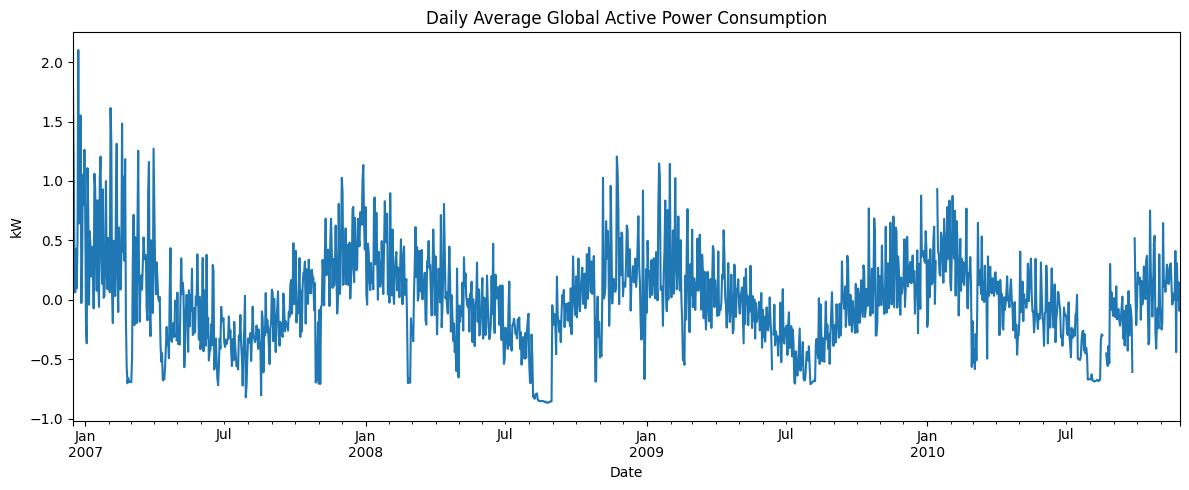

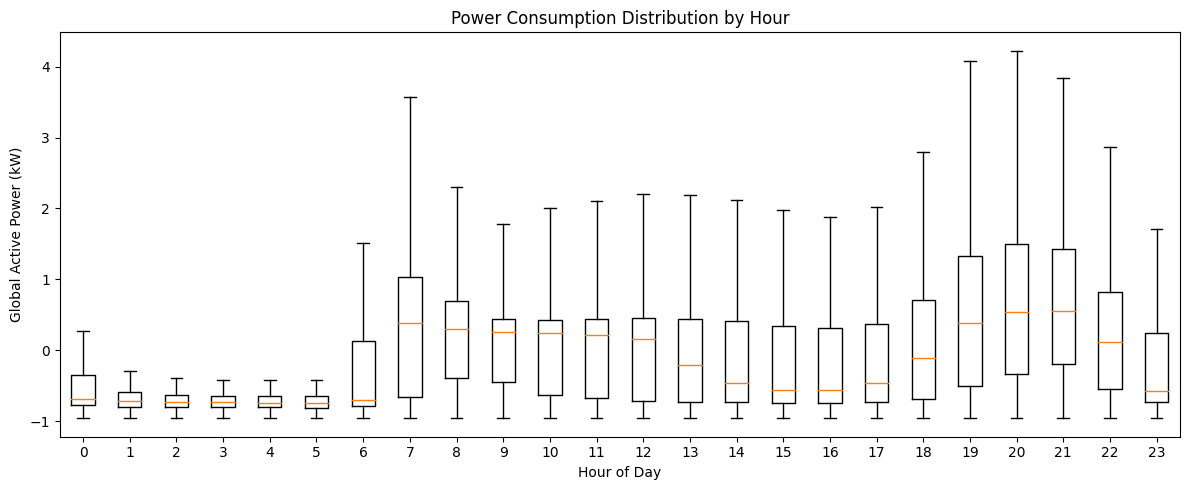

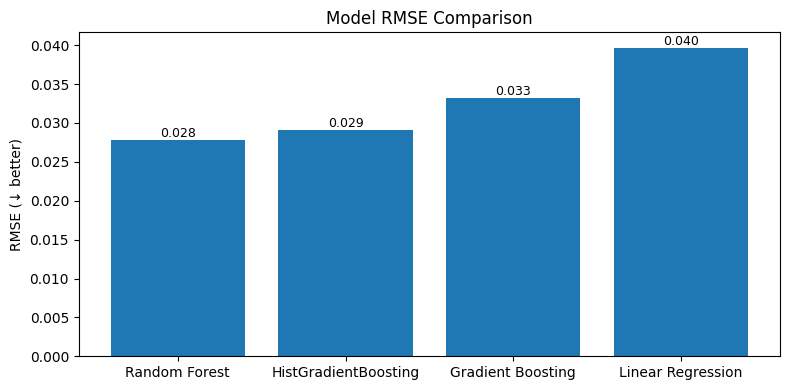

Saved: figures/model_results.csv


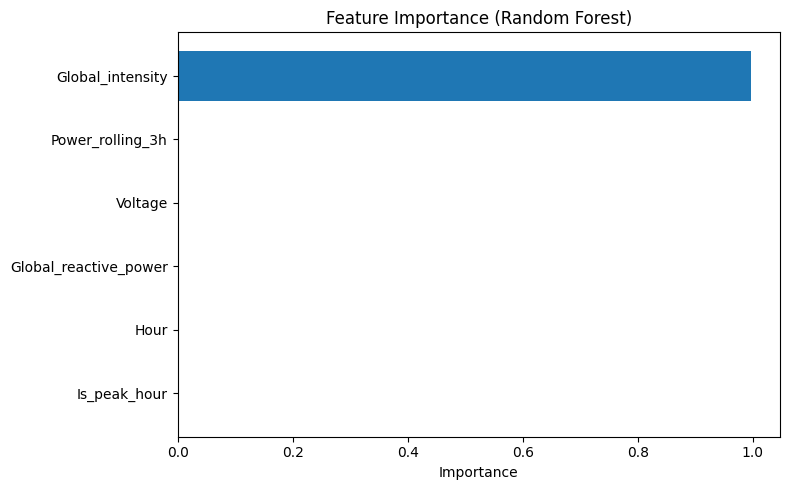

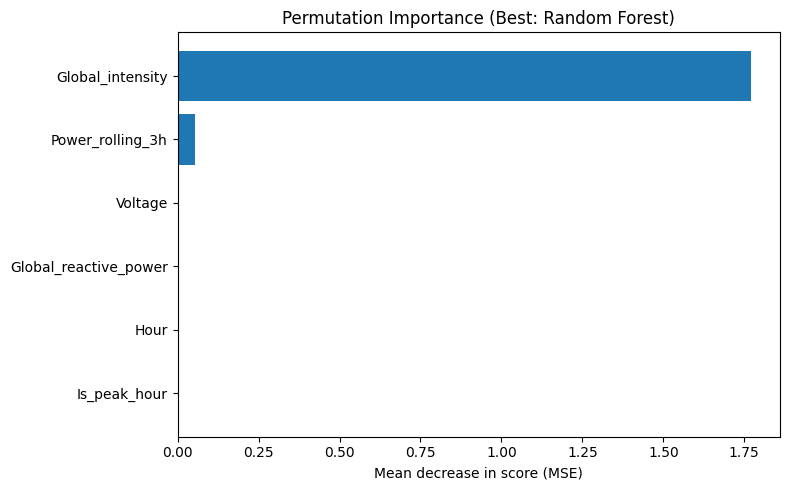

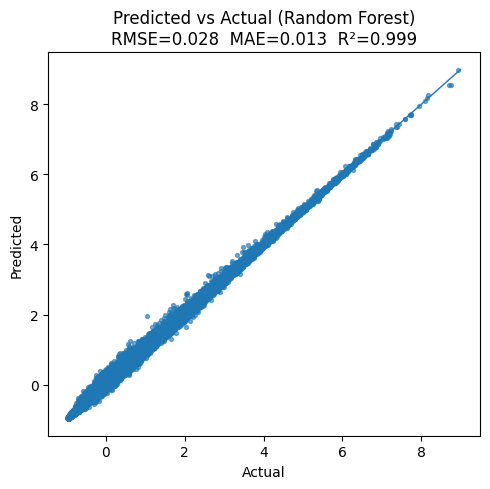

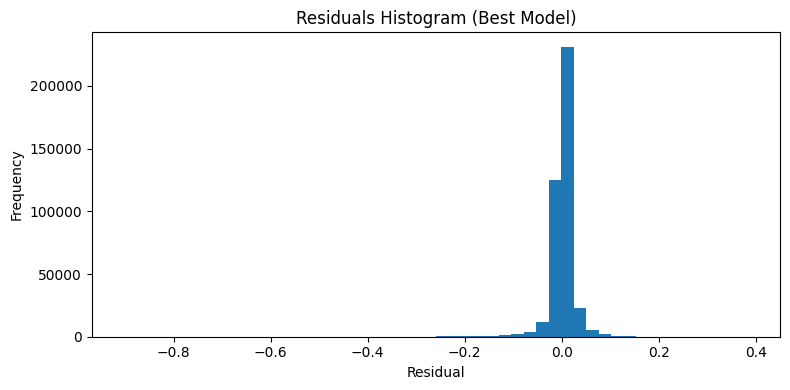

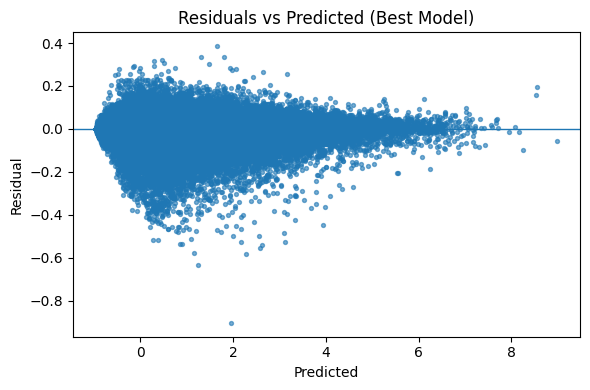

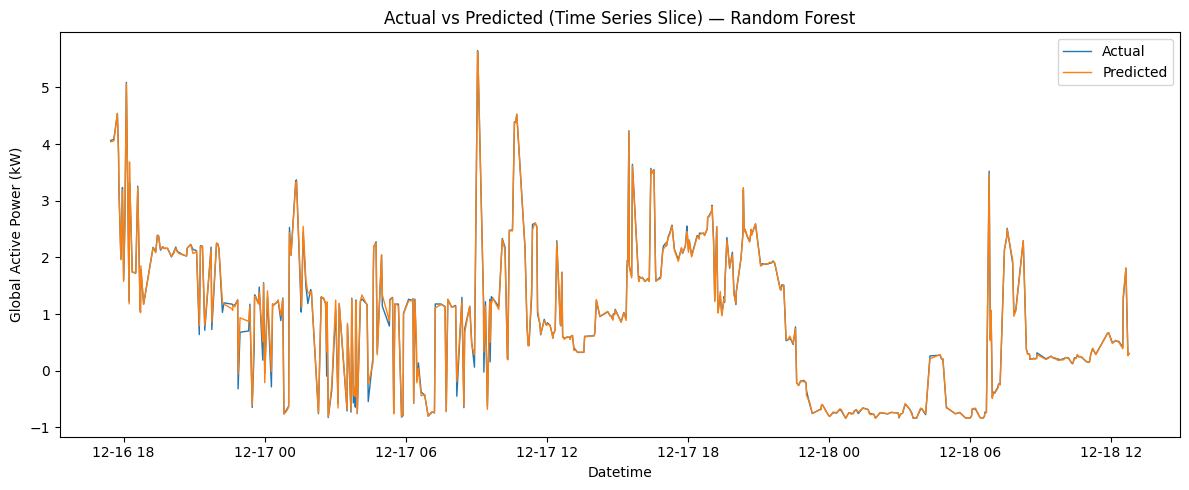

✅ Visualizations generated in the 'figures' folder.


In [9]:
# =========================
# 📊 VISUALIZATION ADD-ONS
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Make a folder for figures (optional)
os.makedirs("figures", exist_ok=True)

# ----------------------------
# 0) Utility: pick best model
# ----------------------------
# Expecting results DataFrame (Model, RMSE, MAE, R2) and pipelines dict from above
best_row = results.sort_values("RMSE", ascending=True).iloc[0]
best_name = best_row["Model"]
best_pipe = pipelines[best_name]

print(f"Best model by RMSE ➜ {best_name}")
print(best_row)

# Fit best model on train for plots
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

# We'll also keep a reference model that exposes feature_importances_ if available
# Prefer Random Forest, fallback to GradientBoosting / HistGradientBoosting if used
tree_candidate_name = None
for candidate in ["Random Forest", "Gradient Boosting", "HistGradientBoosting"]:
    if candidate in pipelines:
        tree_candidate_name = candidate
        break

tree_model = None
if tree_candidate_name is not None:
    tree_pipe = pipelines[tree_candidate_name].fit(X_train, y_train)
    # many scikit-learn pipelines call the model step "model"
    tree_model = tree_pipe.named_steps.get("model", None)

# ----------------------------
# 1) Energy Usage Trends
# ----------------------------
# Assumes df_main has: Datetime and target column (col_gap)
if "Datetime" in df_main.columns and col_gap is not None:
    # Daily average consumption
    daily = (
        df_main.dropna(subset=["Datetime", col_gap])
               .set_index("Datetime")[col_gap]
               .resample("D").mean()
    )
    plt.figure(figsize=(12,5))
    daily.plot()
    plt.title("Daily Average Global Active Power Consumption")
    plt.ylabel("kW")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.savefig("figures/daily_avg_power.png", dpi=160)
    plt.show()

    # Consumption distribution by hour (box-style using matplotlib)
    # Build an array-of-arrays grouped by Hour
    hourly_groups = []
    labels = []
    tmp = df_main.dropna(subset=["Hour", col_gap]).copy()
    for h in range(24):
        grp = tmp.loc[tmp["Hour"] == h, col_gap].values
        hourly_groups.append(grp)
        labels.append(str(h))

    plt.figure(figsize=(12,5))
    plt.boxplot(hourly_groups, labels=labels, showfliers=False)
    plt.title("Power Consumption Distribution by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Global Active Power (kW)")
    plt.tight_layout()
    plt.savefig("figures/hourly_boxplot_power.png", dpi=160)
    plt.show()

# ----------------------------
# 2) Model Comparison (RMSE)
# ----------------------------
plt.figure(figsize=(8,4))
plt.bar(results["Model"], results["RMSE"])
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE (↓ better)")
for i, v in enumerate(results["RMSE"]):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig("figures/model_rmse_comparison.png", dpi=160)
plt.show()

# Also export the table
results.round(4).to_csv("figures/model_results.csv", index=False)
print("Saved: figures/model_results.csv")

# ----------------------------
# 3) Feature Importance (Tree)
# ----------------------------
if tree_model is not None and hasattr(tree_model, "feature_importances_"):
    importances = getattr(tree_model, "feature_importances_", None)
    if importances is not None and len(importances) == len(X_train.columns):
        order = np.argsort(importances)[::-1]
        plt.figure(figsize=(8,5))
        plt.barh(np.array(X_train.columns)[order][::-1], np.array(importances)[order][::-1])
        plt.title(f"Feature Importance ({tree_candidate_name})")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.savefig("figures/feature_importance_tree.png", dpi=160)
        plt.show()

# ----------------------------
# 4) Model-Agnostic Importance (Permutation on best model)
# ----------------------------
perm = permutation_importance(
    best_pipe, X_test, y_test, n_repeats=5, random_state=42, scoring="neg_mean_squared_error"
)
perm_sorted_idx = perm.importances_mean.argsort()

plt.figure(figsize=(8,5))
plt.barh(X_test.columns[perm_sorted_idx], perm.importances_mean[perm_sorted_idx])
plt.title(f"Permutation Importance (Best: {best_name})")
plt.xlabel("Mean decrease in score (MSE)")
plt.tight_layout()
plt.savefig("figures/permutation_importance_best.png", dpi=160)
plt.show()

# ----------------------------
# 5) Predicted vs Actual (Best Model)
# ----------------------------
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6)
min_v = float(min(np.min(y_test), np.min(y_pred)))
max_v = float(max(np.max(y_test), np.max(y_pred)))
plt.plot([min_v, max_v], [min_v, max_v], linewidth=1)
plt.title(f"Predicted vs Actual ({best_name})\n"
          f"RMSE={best_row['RMSE']:.3f}  MAE={best_row['MAE']:.3f}  R²={best_row['R2']:.3f}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig("figures/pred_vs_actual_best.png", dpi=160)
plt.show()

# ----------------------------
# 6) Residual Analysis (Best Model)
# ----------------------------
residuals = y_test - y_pred

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=50)
plt.title("Residuals Histogram (Best Model)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/residuals_hist_best.png", dpi=160)
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, s=8, alpha=0.6)
plt.axhline(0, linewidth=1)
plt.title("Residuals vs Predicted (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.tight_layout()
plt.savefig("figures/residuals_vs_pred_best.png", dpi=160)
plt.show()

# ----------------------------
# 7) Time-Series Slice: Actual vs Predicted
# ----------------------------
# We’ll reconstruct a small, ordered slice on the test set (requires Datetime to exist).
if "Datetime" in df_main.columns:
    # y_test is a pandas Series with original indices retained by train_test_split.
    # We can build a DataFrame with Datetime, y_test, y_pred
    ts_frame = pd.DataFrame({
        "Actual": y_test,
        "Predicted": y_pred
    })
    # Merge the Datetime from the modeling frame; df_model rows map to X/y indices.
    if "Datetime" in df_model.columns:
        ts_frame = ts_frame.join(df_model["Datetime"], how="left")
    # Keep a reasonable continuous window (e.g., earliest 500 rows)
    ts_frame = ts_frame.dropna(subset=["Datetime"]).sort_values("Datetime").head(500)

    plt.figure(figsize=(12,5))
    plt.plot(ts_frame["Datetime"], ts_frame["Actual"], linewidth=1, label="Actual")
    plt.plot(ts_frame["Datetime"], ts_frame["Predicted"], linewidth=1, label="Predicted")
    plt.title(f"Actual vs Predicted (Time Series Slice) — {best_name}")
    plt.xlabel("Datetime")
    plt.ylabel("Global Active Power (kW)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("figures/actual_vs_pred_timeslice.png", dpi=160)
    plt.show()

print("✅ Visualizations generated in the 'figures' folder.")

In [10]:
ts_frame = pd.DataFrame({
        "Actual": y_test,
        "Predicted": y_pred
    })
    # Merge the Datetime from the modeling frame; df_model rows map to X/y indices.
if "Datetime" in df_model.columns:
    ts_frame = ts_frame.join(df_model["Datetime"], how="left")
    # Keep a reasonable continuous window (e.g., earliest 500 rows)
ts_frame = ts_frame.dropna(subset=["Datetime"]).sort_values("Datetime").head(500)


In [11]:
ts_frame

,Actual,Predicted,Datetime
3,4.063567,4.040698,2006-12-16 17:27:00
11,4.086267,4.056114,2006-12-16 17:35:00
20,4.542148,4.537750,2006-12-16 17:44:00
23,3.861164,3.797624,2006-12-16 17:47:00
24,3.199096,3.259448,2006-12-16 17:48:00
...,...,...,...
2585,0.414629,0.387721,2006-12-18 12:29:00
2586,1.250726,1.319222,2006-12-18 12:30:00
2593,1.806863,1.817465,2006-12-18 12:37:00
2598,0.270866,0.263725,2006-12-18 12:42:00


In [14]:
ts_frame["Datetime"]

3      2006-12-16 17:27:00
11     2006-12-16 17:35:00
20     2006-12-16 17:44:00
23     2006-12-16 17:47:00
24     2006-12-16 17:48:00
               ...        
2585   2006-12-18 12:29:00
2586   2006-12-18 12:30:00
2593   2006-12-18 12:37:00
2598   2006-12-18 12:42:00
2601   2006-12-18 12:45:00
Name: Datetime, Length: 500, dtype: datetime64[ns]

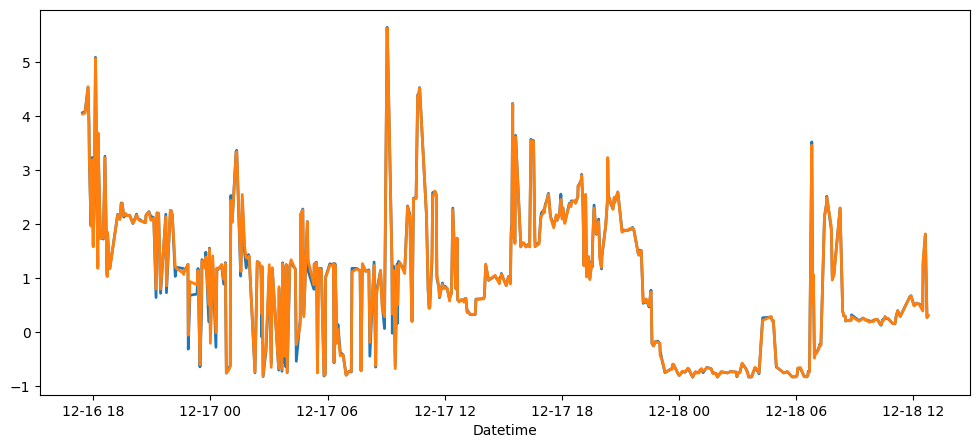

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(ts_frame["Datetime"], ts_frame["Actual"], linewidth=1, label="Actual")
plt.plot(ts_frame["Datetime"], ts_frame["Predicted"], linewidth=1, label="Predicted")    
# plt.title(f"Actual vs Predicted (Time Series Slice) — {best_name}")
plt.xlabel("Datetime")
# plt.ylabel("Global Active Power (kW)")
# plt.legend()
# plt.tight_layout()
# plt.savefig("figures/actual_vs_pred_timeslice.png", dpi=160)
plt.show()